# Image Classification | CIFAR-10 with ResNet50

### 1 - Notebook Overview

This notebook builds an image classification model using **transfer learning** with a pre-trained `ResNet50` network to categorize `CIFAR-10` images into 10 classes. The workflow follows a two-phase training approach:

- **Data Loading:** Loading the `CIFAR-10` dataset and limiting to 10,000 training samples.
- **Preprocessing:** Normalizing pixel values for `ResNet50` compatibility.
- **Model Architecture:** Using `ResNet50` (`ImageNet` weights) as a feature extractor with a custom classification head.
- **Phase 1 Training:** Training only the classification head while keeping `ResNet50` layers frozen.
- **Phase 2 Fine-tuning:** Unfreezing the base model and training end-to-end with a lower learning rate.
- **Evaluation:** Assessing model performance on the test set and analyzing training curves.

---

### 2 - Import Libraries

In [25]:
# Core Libraries
import pandas as pd
import numpy as np

# Data
from tensorflow.keras.datasets import cifar10

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Model building
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Model Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Exclude warnings
import warnings
warnings.filterwarnings('ignore')

### 3 - Load Dataset

In [2]:
# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
# Limit training data for faster experimentation
n = 10000
train_images = train_images[:n]
train_labels = train_labels[:n]

### 4 - Data Exploration

In [4]:
# Check dataset shapes
print("--- CIFAR-10 Dataset Shapes ---")
print(f"Training images: {train_images.shape}")
print(f"Training labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}")
print(f"Test labels: {test_labels.shape}")

--- CIFAR-10 Dataset Shapes ---
Training images: (10000, 32, 32, 3)
Training labels: (10000, 1)
Test images: (10000, 32, 32, 3)
Test labels: (10000, 1)


In [5]:
#Flatten labels for further inspection
flat_labels = train_labels.flatten()

# Count images per class
pd.Series(flat_labels).value_counts().sort_index()

0    1005
1     974
2    1032
3    1016
4     999
5     937
6    1030
7    1001
8    1025
9     981
Name: count, dtype: int64

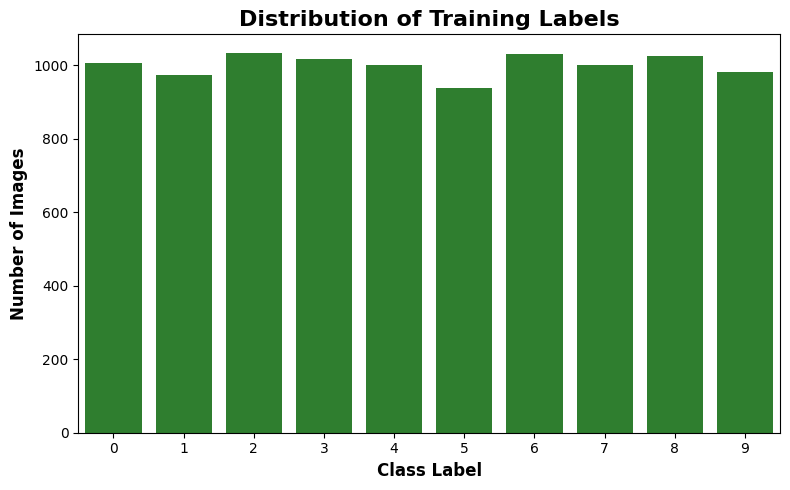

In [32]:
# Visualize label distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=flat_labels, color='forestgreen')
plt.title('Distribution of Training Labels', fontsize=16, fontweight='bold')
plt.xlabel('Class Label', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.tight_layout()

# Export and show plot
plt.savefig('../visualizations/distribution-training-labels.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Define class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

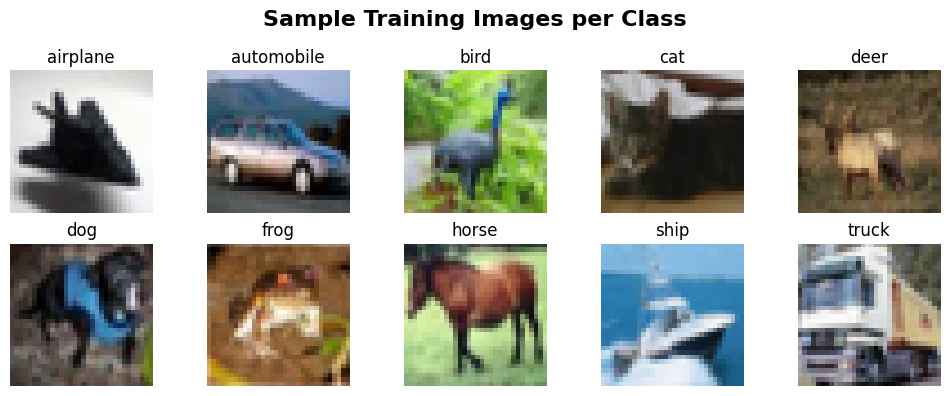

In [33]:
# View one sample image per class
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    # Find the first occurrence of each class
    idx = np.where(flat_labels == i)[0][0]
    ax.imshow(train_images[idx])
    ax.set_title(classes[i])
    ax.axis('off')

plt.suptitle('Sample Training Images per Class', fontsize=16, fontweight='bold')
plt.tight_layout()

# Export and show plot
plt.savefig('../visualizations/sample-training-images.png', dpi=300, bbox_inches='tight')
plt.show()

**Observations:**
- **Balanced classes:** Each class contains approximately 1,000 images (of the 10,000 sample), so no resampling or class weighting is needed.
- **Image quality:** The 32x32 resolution is low, making some objects difficult to distinguish even visually. This is a known challenge with `CIFAR-10` compared to higher-resolution datasets.
- **Color images:** Unlike grayscale datasets, these RGB images contain color information that the model can leverage for classification.

### 5 - Preprocessing

Unlike traditional neural networks that require flattened input vectors, CNNs like `ResNet50` expect images to retain their spatial structure (height × width × channels). The images remain as (32, 32, 3) arrays—no reshaping needed. However, neural networks train more effectively when input values are small. Normalizing raw pixel values from (0–255) to (0–1) improves gradient flow and training stability.

In [9]:
# Normalize pixel values to 0-1 range
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

### 6 - Model Architecture

In [10]:
# Load ResNet50 base model (without top classification layer)
base_model = ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet'
)

In [11]:
# Freeze base model so only the custom head trains (preserves ImageNet features)
base_model.trainable = False

# Build model with custom classification head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# View model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,858,890 (91.01 MB)

 Trainable params: 271,178 (1.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

The summary confirms ~23.5M parameters are frozen (`ResNet50` base) while only ~271K parameters in the custom head are trainable. This is the intended setup for Phase 1.

### 7 - Phase 1: Train Classification Head

With the `ResNet50` base frozen, only the custom classification head (~271K parameters) will be trained. This allows the model to learn how to map `ResNet50`'s pre-trained features to `CIFAR-10`'s 10 classes without altering the base model's learned representations.

In [12]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Train classification head (base model is frozen)
history_phase1 = model.fit(
    train_images,
    train_labels,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.1430 - loss: 2.2957 - val_accuracy: 0.1765 - val_loss: 2.2138
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.1920 - loss: 2.1809 - val_accuracy: 0.2040 - val_loss: 2.1264
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.2219 - loss: 2.0765 - val_accuracy: 0.2815 - val_loss: 2.0027
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.2690 - loss: 2.0069 - val_accuracy: 0.2415 - val_loss: 2.0185
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.2659 - loss: 1.9848 - val_accuracy: 0.3020 - val_loss: 1.9368
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.2980 - loss: 1.9251 - val_accuracy: 0.2965 - val_loss: 1.9279
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.3039 - loss: 1.9037 - val_accuracy: 0.2880 - val_loss: 1.9217
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.3047 - loss: 1.8931 - val_accu

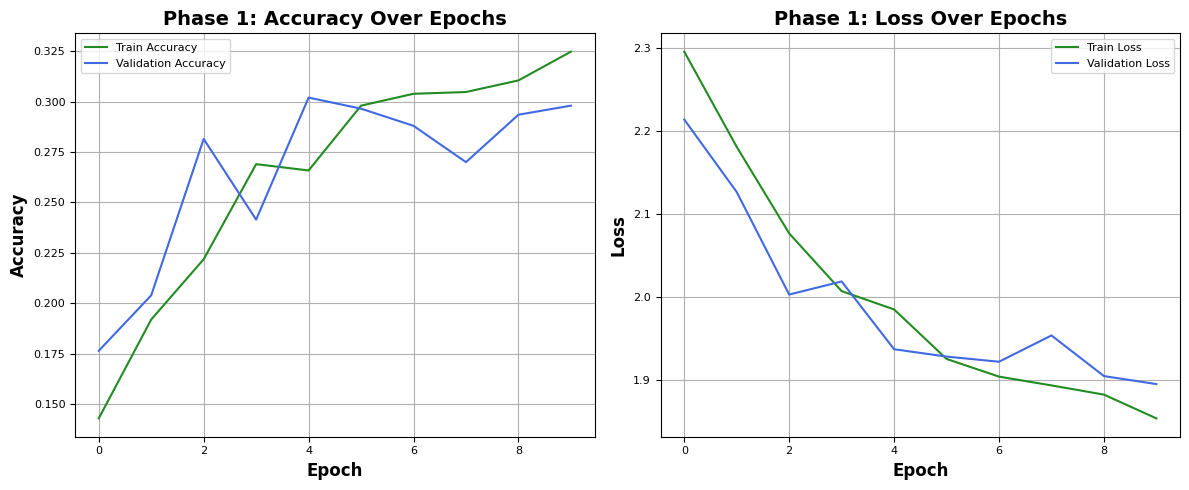

In [34]:
# Plot Phase 1 training history
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
axes[0].plot(history_phase1.history['accuracy'], label='Train Accuracy', color='forestgreen')
axes[0].plot(history_phase1.history['val_accuracy'], label='Validation Accuracy', color='royalblue')
axes[0].set_title('Phase 1: Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=8)
axes[0].legend(fontsize=8)
axes[0].grid(True)

# Loss
axes[1].plot(history_phase1.history['loss'], label='Train Loss', color='forestgreen')
axes[1].plot(history_phase1.history['val_loss'], label='Validation Loss', color='royalblue')
axes[1].set_title('Phase 1: Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=8)
axes[1].legend(fontsize=8)
axes[1].grid(True)

plt.tight_layout()

# Export and show plot
plt.savefig('../visualizations/phase1-accuracy-loss-over-epochs.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
print(f"Final Training Accuracy: {history_phase1.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_phase1.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history_phase1.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_phase1.history['val_loss'][-1]:.4f}")

Final Training Accuracy: 0.3248
Final Validation Accuracy: 0.2980
Final Training Loss: 1.8533
Final Validation Loss: 1.8947


**Phase 1 Observations:**
- **Modest accuracy (~30%):** Expected when training only the classification head. The frozen `ResNet50` features were learned on 224×224 `ImageNet` images that were not optimized for 32×32 `CIFAR-10` images.
- **No overfitting:** The small gap between training (32.5%) and validation (29.8%) accuracy indicates the model generalizes well to unseen data.
- **Loss decreasing:** Training loss dropped from 2.29 to 1.85, confirming the model is learning despite the frozen base.
- **Room for improvement:** Phase 2 fine-tuning should significantly boost performance by allowing the base model to adapt its features to `CIFAR-10`'s smaller images.

### 8 - Phase 2: Fine-tune Full Model

Now that the classification head has learned a reasonable mapping, we unfreeze the `ResNet50` base and fine-tune the entire network. A much lower learning rate (1e-5) is used to make small adjustments to the pre-trained weights without destroying the features learned from `ImageNet`.

In [16]:
# Unfreeze base model for fine-tuning
base_model.trainable = True

In [17]:
# Recompile with lower learning rate (prevents destroying pre-trained features)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
# Fine-tune entire model
history_phase2 = model.fit(
    train_images,
    train_labels,
    epochs=10,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 684ms/step - accuracy: 0.2186 - loss: 2.3732 - val_accuracy: 0.1080 - val_loss: 92.1506
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 680ms/step - accuracy: 0.2765 - loss: 2.0849 - val_accuracy: 0.1205 - val_loss: 117.9540
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 679ms/step - accuracy: 0.3236 - loss: 1.8929 - val_accuracy: 0.1130 - val_loss: 48.3336
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 87s 698ms/step - accuracy: 0.3791 - loss: 1.7106 - val_accuracy: 0.0890 - val_loss: 12.6455
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 684ms/step - accuracy: 0.4226 - loss: 1.5802 - val_accuracy: 0.1700 - val_loss: 3.8972
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 88s 701ms/step - accuracy: 0.4621 - loss: 1.4710 - val_accuracy: 0.2545 - val_loss: 2.4872
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 92s 733ms/step - accuracy: 0.4940 - loss: 1.3850 - val_accuracy: 0.3260 - val_loss: 2.1279
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 686ms/step - accuracy: 0.5400 - lo

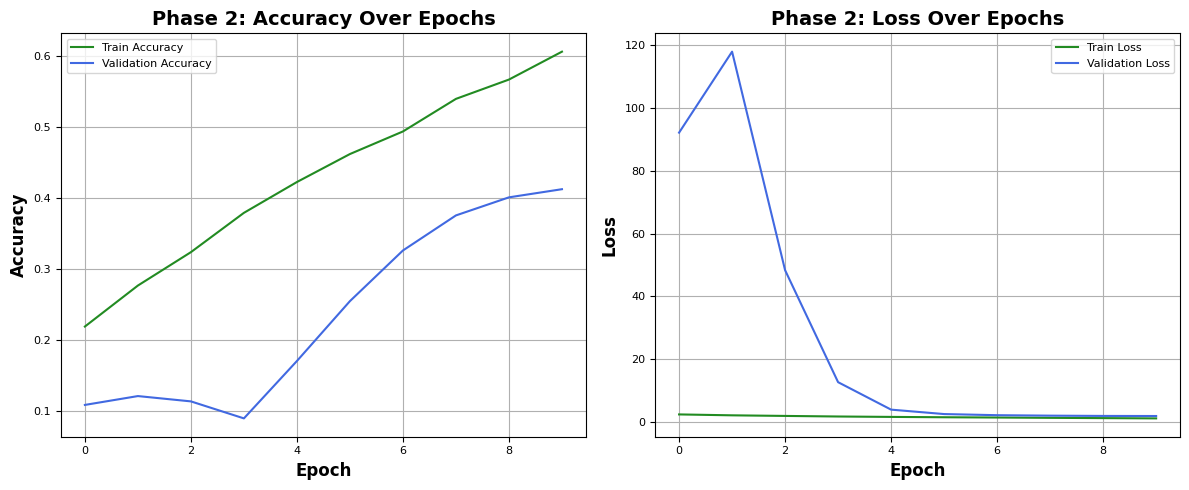

In [35]:
# Plot Phase 2 training history
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
axes[0].plot(history_phase2.history['accuracy'], label='Train Accuracy', color='forestgreen')
axes[0].plot(history_phase2.history['val_accuracy'], label='Validation Accuracy', color='royalblue')
axes[0].set_title('Phase 2: Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=8)
axes[0].legend(fontsize=8)
axes[0].grid(True)

# Loss
axes[1].plot(history_phase2.history['loss'], label='Train Loss', color='forestgreen')
axes[1].plot(history_phase2.history['val_loss'], label='Validation Loss', color='royalblue')
axes[1].set_title('Phase 2: Loss Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=8)
axes[1].legend(fontsize=8)
axes[1].grid(True)

plt.tight_layout()

# Export and show plot
plt.savefig('../visualizations/phase2-accuracy-loss-over-epochs.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
print(f"Final Training Accuracy: {history_phase2.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_phase2.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history_phase2.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_phase2.history['val_loss'][-1]:.4f}")

Final Training Accuracy: 0.6066
Final Validation Accuracy: 0.4125
Final Training Loss: 1.1099
Final Validation Loss: 1.8654


**Phase 2 Observations:**
- **Significant improvement:** Training accuracy jumped from 32.5% to 60.7%, and validation accuracy improved from 29.8% to 41.3%.
- **Overfitting present:** The ~19% gap between training and validation accuracy suggests the model is starting to memorize training data rather than learning generalizable patterns. This is expected given the small dataset (8,000 training samples) relative to the 23.5M parameters now being trained.
- **Unstable early training:** Validation loss spiked in early epochs before stabilizing, indicating the base model weights needed time to adjust to the new learning signal.
- **Continued learning:** Validation accuracy was still improving at epoch 10, suggesting additional training could help—though regularization (dropout, data augmentation) would be needed to control overfitting.

### 9 - Evaluation & Results

Now that training is complete, I evaluate the model on the test set—data it has never seen during training or validation. This provides an unbiased measure of how well the model generalizes. I assess overall accuracy and examine per-class performance using a classification report to identify which categories the model handles well and where it struggles.

In [22]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.8814
Test Accuracy: 0.4024


In [24]:
# Classification report
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_labels, y_pred, target_names=classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
              precision    recall  f1-score   support

    airplane       0.42      0.45      0.43      1000
  automobile       0.46      0.44      0.45      1000
        bird       0.32      0.28      0.30      1000
         cat       0.30      0.30      0.30      1000
        deer       0.36      0.37      0.37      1000
         dog       0.39      0.30      0.34      1000
        frog       0.40      0.50      0.44      1000
       horse       0.42      0.41      0.42      1000
        ship       0.49      0.52      0.51      1000
       truck       0.43      0.44      0.43      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.40     10000
weighted avg       0.40      0.40      0.40     10000



**Evaluation Results:**
- **Test accuracy:** 40.2% is consistent with the validation accuracy (41.3%), confirming the model generalizes as expected.
- **Best classes:** `ship` (51%), `automobile` (45%), and `frog` (44%) - likely because these objects have more distinctive shapes or colors.
- **Worst classes:** `bird` (30%), `cat` (30%), `dog` (34%) - likely because they are visually more complex objects that are harder to distinguish at low resolution.
- **Overall:** The model performs 4 times better than random guessing (10%), but accuracy is limited by the small training set and low image resolution.

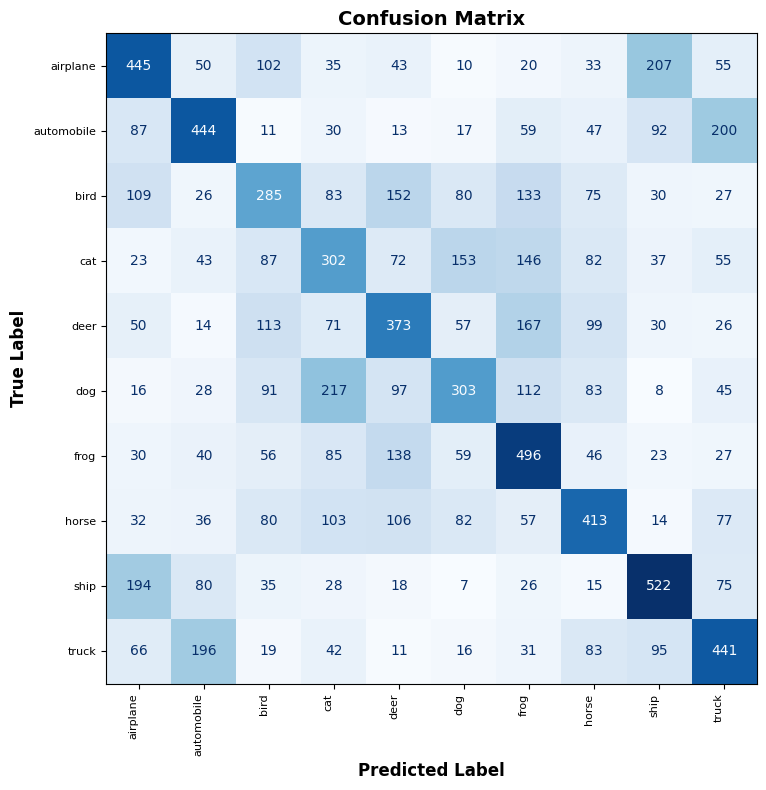

In [36]:
# Visualize which classes are being misclassified
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()

# Export and show plot
plt.savefig('../visualizations/confusion-matrix.png', dpi=300, bbox_inches='tight')
plt.show()

**Confusion Matrix Insights:**
- **Vehicle confusion:** `automobile` and `truck` are frequently confused with each other (~200 each way), as are `airplane` and `ship` (207) — likely due to similar shapes and backgrounds.
- **Animal confusion:** `cat` and `dog` show bidirectional confusion (153 and 217), which is expected given their similar furry textures at low resolution.
- **Best distinguished:** `ship` (522 correct) and `frog` (496 correct) have the most distinctive features.
- **Most confused:** `bird` (285 correct) struggles most, often misclassified as `airplane`, `deer`, or `frog`.

In [37]:
# Calculate number of correct and wrong predictions
correct_predictions = np.where(y_pred == test_labels.flatten())[0]
wrong_predictions = np.where(y_pred != test_labels.flatten())[0]
print(f"{correct_predictions.shape[0]} Correct out of 10,000")
print(f"{wrong_predictions.shape[0]} Incorrect out of 10,000")

4024 Correct out of 10,000
5976 Incorrect out of 10,000


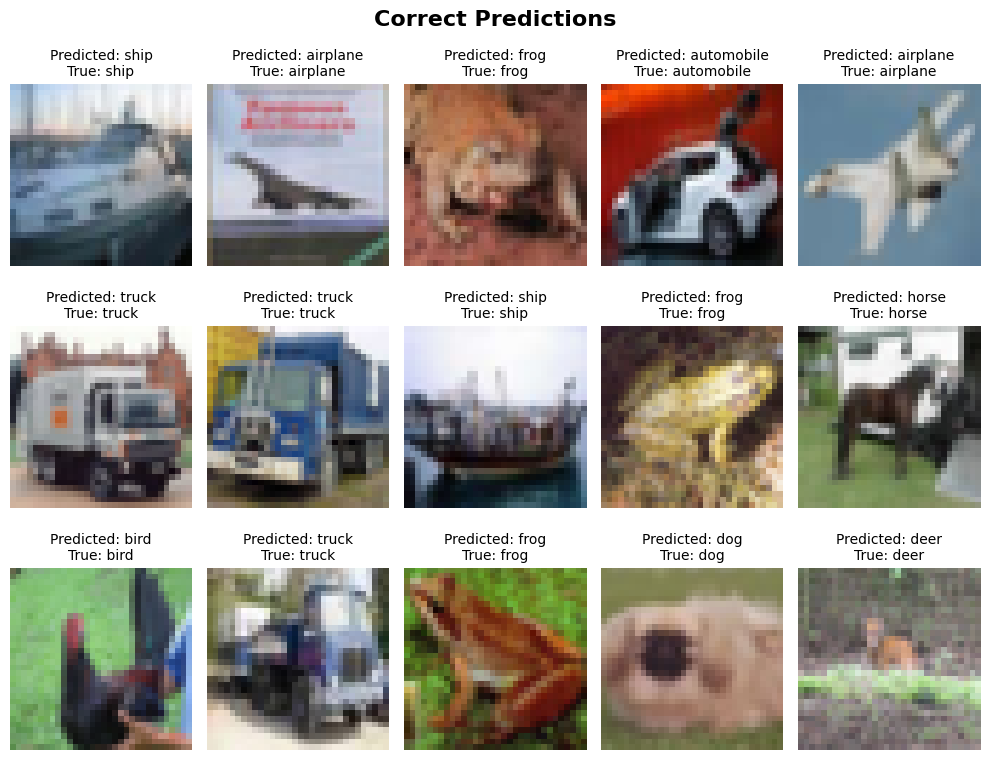

In [40]:
# Visually confirm correct predictions
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    idx = correct_predictions[i]
    ax.imshow(test_images[idx])
    ax.set_title(f"Predicted: {classes[y_pred[idx]]}\nTrue: {classes[test_labels[idx][0]]}", fontsize=10)
    ax.axis('off')

plt.suptitle('Correct Predictions', fontsize=16, fontweight='bold')
plt.tight_layout()

# Export and show plot
plt.savefig('../visualizations/predictions-correct.png', dpi=300, bbox_inches='tight')
plt.show()

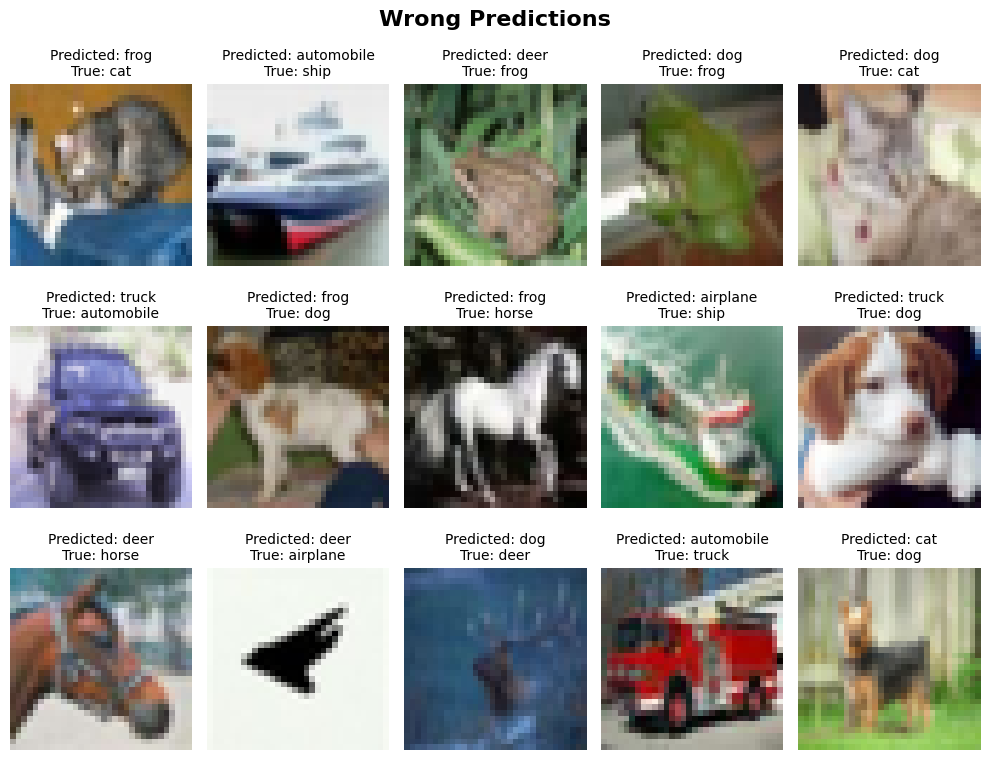

In [41]:
# Visually confirm wrong predictions
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    idx = wrong_predictions[i]
    ax.imshow(test_images[idx])
    ax.set_title(f"Predicted: {classes[y_pred[idx]]}\nTrue: {classes[test_labels[idx][0]]}", fontsize=10)
    ax.axis('off')

plt.suptitle('Wrong Predictions', fontsize=16, fontweight='bold')
plt.tight_layout()

# Export and show plot
plt.savefig('../visualizations/predictions-wrong.png', dpi=300, bbox_inches='tight')
plt.show()